# Classification Example analysis
#### Methods:
- Logistic Regression
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- K-Nearest Neighbors (KNN)
- Gaussian Naive Bayes (GNB)
#### Dataset:
- Weekly from ISLP package

We know that data are barely correlated, but even then we can test these methods and optimize hyperparameters. (see optimization notebook)

## (1) Load data and check for correlations

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

import statsmodels.api as sm

from sklearn.discriminant_analysis import \
        (LinearDiscriminantAnalysis as LDA,
        QuadraticDiscriminantAnalysis as QDA)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
# Change to boolean instead of string
Weekly['Direction'] = Weekly['Direction'] == 'Up'

In [4]:
Weekly.drop(columns=['Direction']).corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


We can see that `Volume` correlates with `Year`. So we plot them.

<Axes: xlabel='Year', ylabel='Volume'>

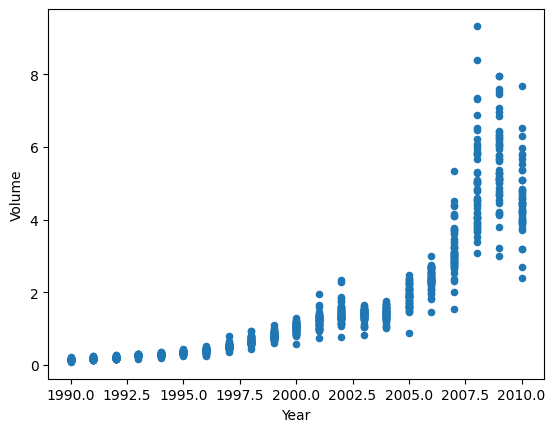

In [5]:
Weekly.plot(y='Volume', x='Year', kind='scatter')

## (2) Prepare data for classification
- Create train/test split based on year. Train data <= 2008, test data > 2008. We will use `Lag2` as feature.
- Visualize data to choose methods.

In [21]:
# Prepare data
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
y = Weekly['Direction']
train = Weekly['Year'] <= 2008
test = ~train


X_train, X_test =  X.loc[train], X.loc[test]
y_train, y_test = y.loc[train], y.loc[test]


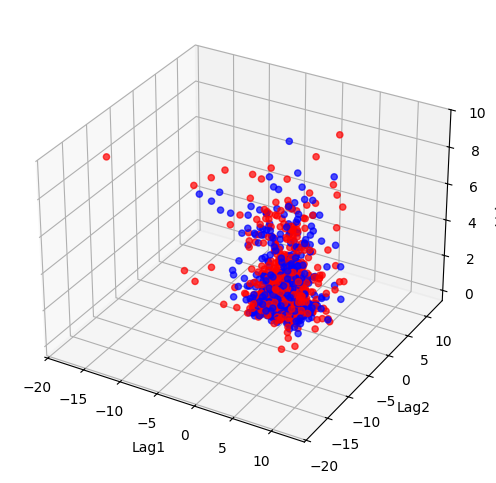

In [7]:
# plot Direction up to Lag2 and Lag1 and Lag3 3d
plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.scatter3D(Weekly['Lag1'], Weekly['Lag2'], Weekly['Volume'],
             c=(Weekly['Direction']), cmap='bwr', alpha=0.7)
ax.set_xlabel('Lag1')
ax.set_ylabel('Lag2')
ax.set_zlabel('Volume')

plt.show()


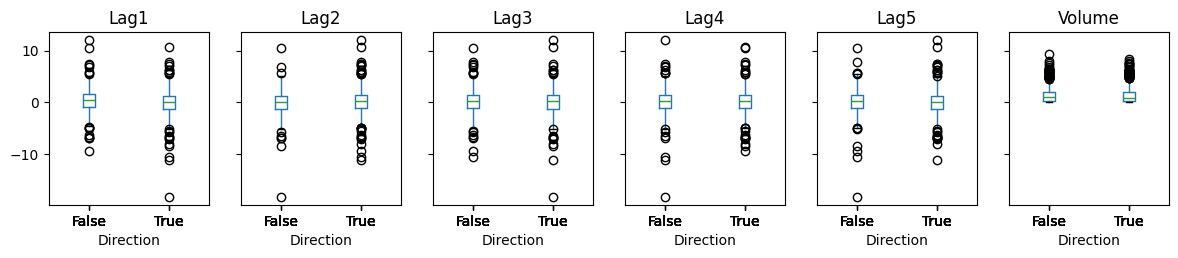

In [8]:
# Box plot of lag1 ... lag2 grouped by Direction
Weekly.boxplot(column=['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'],
               by='Direction', grid=False,
               figsize=(14,2.3), layout=(1,6), )
plt.suptitle("")
print()

We can see that none of the features is strongly correlated with Direction. So we can try different classification methods and see which one performs best.

## (3) Fit classification models

### a) Fit Bionomial model

In [9]:
# GLM - generalized linear model
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm.fit()
summarize(results)


,coef,std err,z,P>|z|
intercept,0.2033,0.064,3.162,0.002
Lag2,0.0581,0.029,2.024,0.043


Accuracy: 0.625


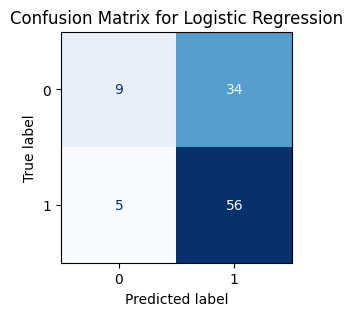

In [10]:
# test predictions
probs_test = results.predict(X_test)

plt.figure(figsize = (3,3))
ConfusionMatrixDisplay(confusion_matrix(y_test,probs_test>=0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix for Logistic Regression")
print("Accuracy:",accuracy_score(y_test, probs_test>=0.5))

### b) LDA

In [11]:
lda = LDA(store_covariance=True)
model_result = lda.fit(X_train, y_train)
lda.priors_

array([0.44771574, 0.55228426])

Accuracy: 0.625


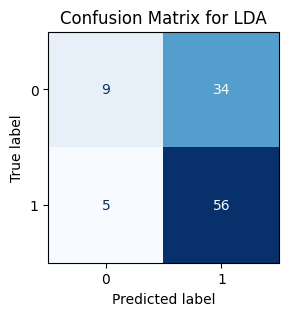

In [12]:
lda_pred = model_result.predict(X_test)
plt.figure(figsize = (3,3))
ConfusionMatrixDisplay(confusion_matrix(y_test, lda_pred>=0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix for LDA")
print("Accuracy:",accuracy_score(y_test, lda_pred>=0.5))

In [13]:
lda.covariance_

array([[0.        , 0.        ],
       [0.        , 5.12177761]])

### c) QDA

Accuracy: 0.5865384615384616


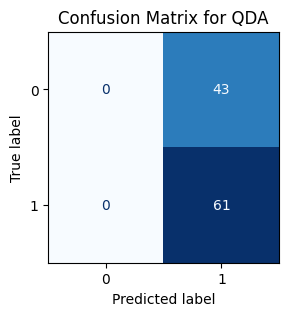

In [14]:
qda = QDA(store_covariance=True, reg_param=0.1)
model_result = qda.fit(X_train, y_train)
qda_pred = model_result.predict(X_test)

plt.figure(figsize = (3,3))
ConfusionMatrixDisplay(confusion_matrix(y_test,qda_pred>=0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix for QDA")
print("Accuracy:",accuracy_score(y_test, qda_pred>=0.5))

reg_param $\lambda$ is used to reduce influence of covariance matrix in way $\sum_{k}^{(reg)}=(1-\lambda)\sum_{k}  +  \lambda I$

I - identity matrix
### d) KNN K=1

Accuracy: 0.5


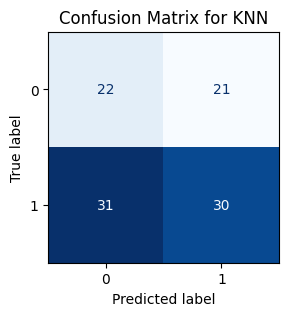

In [15]:
knn = KNeighborsClassifier(n_neighbors=1)
model_result = knn.fit(X_train, y_train)
knn_pred = model_result.predict(X_test)

plt.figure(figsize = (3,3))
ConfusionMatrixDisplay(confusion_matrix(y_test, knn_pred>0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix for KNN")
print("Accuracy:",accuracy_score(y_test, knn_pred>=0.5))

#### e) Gaussian Naive Bayes

Accuracy: 0.5865384615384616


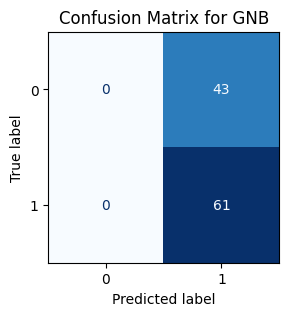

In [16]:
nb = GaussianNB()
model_result = nb.fit(X_train, y_train)
nb_pred = model_result.predict(X_test)

plt.figure(figsize = (3,3))
ConfusionMatrixDisplay(confusion_matrix(y_test, nb_pred>0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix for GNB")
print("Accuracy:",accuracy_score(y_test, nb_pred>=0.5))

It is important to remember formula for Gaussian Naive Bayes:
$P(Y=k|X=x) = \frac{P(X=x|Y=k)P(Y=k)}{P(X=x)}$ where **P(Y=k) = $\pi_{k}$**. (see z-test). Where $\pi_{k}$** might significantly influence the results.

## (4) Experiment with parameters

In [19]:
# Test different K values for KNN

for i in range(1,7):
    knn = KNeighborsClassifier(n_neighbors=i)
    model_result = knn.fit(X, y)
    knn_pred = model_result.predict(X)
    acc = np.mean(knn_pred == (Weekly['Direction'] == 'Up'))
    print(f"i={i}: ", round(float(acc),2), end="  |  ")


i=1:  0.44  |  i=2:  0.72  |  i=3:  0.41  |  i=4:  0.61  |  i=5:  0.39  |  i=6:  0.56  |  

Accuracy: 0.5769 



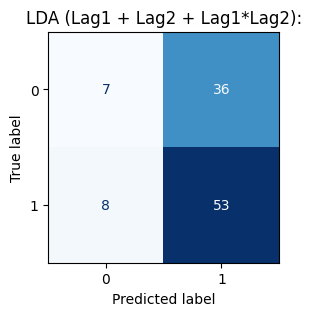

In [18]:
# Test more features
X_train2 = Weekly.loc[train, ['Lag1', 'Lag2', 'Lag1']]
X_test2  = Weekly.loc[test,  ['Lag1', 'Lag2', 'Lag1']]

y_train = Weekly.loc[train]['Direction']
y_test  = Weekly.loc[test]['Direction']

X_train_lda2 = Weekly.loc[train, ['Lag1', 'Lag2']].copy()
X_train_lda2['Lag1*Lag2'] = X_train_lda2['Lag1'] * X_train_lda2['Lag2']
X_test_lda2 = Weekly.loc[test, ['Lag1', 'Lag2']].copy()
X_test_lda2['Lag1*Lag2'] = X_test_lda2['Lag1'] * X_test_lda2['Lag2']

lda2 = LDA(store_covariance=True)
lda2.fit(X_train_lda2, y_train)
lda_pred = lda2.predict(X_test_lda2)

plt.figure(figsize = (3, 3))
plt.title("LDA (Lag1 + Lag2 + Lag1*Lag2):")
ConfusionMatrixDisplay(confusion_matrix(y_test, lda_pred>=0.5)).plot(cmap="Blues", ax=plt.gca(), colorbar=False)
print("Accuracy:", round(accuracy_score(y_test, lda_pred>=0.5), 4), "\n")

This notebook demonstrated fitting different classification models on the Weekly dataset from ISLP package. But even those models can be further optimized better.  <br>